In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.special import comb, perm
import time

m = 50 # m = n = l, number of data in a single dataset
rep = 100 # num of repeated experiments
#n_step = 1000 # num of steps

mu = np.array([-0.1,0,0.1]) # Mean value of three groups
sigma = np.array([1,1,1]) # Variance of data

In [ ]:
# Simulation i.i.d. data points with the given normal distribution.
x = np.random.normal(loc = mu[0], scale = sigma[0], size = m)
y = np.random.normal(loc = mu[1], scale = sigma[1], size = m)
z = np.random.normal(loc = mu[2], scale = sigma[2], size = m)
data = np.concatenate((x,y,z))
grand_mean = np.mean(data)

f0stat, p0value = f_oneway(x,y,z)
p0value

0.7992667543012691

In [ ]:
comb(3*m,m) * comb(2*m, m)

2.0308076630845935e+69

In [ ]:
# standard permutation test
n_step1 = 1000 # num of steps
start_time = time.time()

perm_pvalue = np.zeros([rep, n_step1])
perm_fstat = np.zeros([rep, n_step1])
for itr in range(rep):
    for step in range(n_step1):
        combined_data = np.copy(data)
        np.random.shuffle(combined_data)
        new_x, new_y, new_z = np.split(combined_data, 3)
        perm_fstat[itr][step] = f_oneway(new_x, new_y, new_z)[0]
        perm_pvalue[itr][step] = sum(perm_fstat[itr, 0:(step+1)] > f0stat) / (step + 1)

result_perm = np.mean(perm_pvalue, axis = 0)

end_time = time.time()
perm_time = end_time - start_time
print(perm_time)

168.9939568042755


In [ ]:
def two_way(array1, array2, array3, fstat, mu, var, grand_mean):
    m = len(array1)
    arrays = [array1, array2, array3] # Combine the arrays into a list
    update_mu = np.copy(mu)
    update_var = np.copy(var)
    array_indices = random.sample(range(len(arrays)), 2) # Randomly select indices of two different arrays
    index1 = np.random.randint(len(arrays[array_indices[0]])) # Randomly select one index from each selected array
    index2 = np.random.randint(len(arrays[array_indices[1]]))
    # Exchange the data points at the randomly selected indices and update the original data
    arrays[array_indices[0]][index1], arrays[array_indices[1]][index2] = arrays[array_indices[1]][index2], arrays[array_indices[0]][index1]
    yj = arrays[array_indices[0]][index1]; xi = arrays[array_indices[1]][index2]
    update_mu[array_indices[0]] += (yj - xi) / m
    update_mu[array_indices[1]] += (xi - yj) / m
    update_var[array_indices[0]] += (yj ** 2 - xi ** 2) / (m-1) + m / (m-1) * (mu[array_indices[0]] ** 2 - update_mu[array_indices[0]] ** 2)
    update_var[array_indices[1]] += (xi**2-yj**2)/(m-1) + m/(m-1)*(mu[array_indices[1]] ** 2 - update_mu[array_indices[1]] ** 2)
    fstat = 3*m/2 * np.sum((update_mu - grand_mean) ** 2) / np.sum(update_var)
    return array1, array2, array3, fstat, update_mu, update_var

In [ ]:
# Two-way Transposition Test
n_step2 = 1100 # num of steps
start_time = time.time()

twoway_pvalue = np.zeros([rep, n_step2])
twoway_fstat = np.zeros([rep, n_step2])
for itr in range(rep):
    new_x = np.copy(x); new_y = np.copy(y); new_z = np.copy(z)
    fstat = f_oneway(new_x, new_y, new_z)[0]; mu = np.array([np.mean(new_x), np.mean(new_y), np.mean(new_z)])
    var = np.array([np.var(new_x, ddof=1), np.var(new_y, ddof=1), np.var(new_z, ddof=1)])
    for step in range(n_step2):       
        new_x, new_y, new_z, fstat, mu, var = two_way(new_x, new_y, new_z, fstat, mu, var, grand_mean)
        twoway_fstat[itr][step] = np.copy(fstat)
        twoway_pvalue[itr][step] = sum(twoway_fstat[itr, 0:(step+1)] > f0stat) / (step + 1)

result_twoway = np.mean(twoway_pvalue, axis = 0)

end_time = time.time()
twoway_time = end_time - start_time
print(twoway_time)

167.64854836463928


In [ ]:
def circle_way(array1, array2, array3, fstat, mu, var, grand_mean):
    m = len(array1)
    arrays = [array1, array2, array3] # Combine the arrays into a list
    update_mu = np.copy(mu)
    update_var = np.copy(var)
    
    index_x = np.random.randint(len(array1))
    index_y = np.random.randint(len(array2))
    index_z = np.random.randint(len(array3))
    direction = random.choice(["clock", "counter"])
    if direction == "clock":
       update_mu[0] += (array3[index_z] - array1[index_x])/m # Update mu_x
       update_mu[1] += (array1[index_x] - array2[index_y])/m # update mu_y
       update_mu[2] += (array2[index_y] - array3[index_z])/m # update mu_z
       update_var[0] += (array3[index_z] ** 2 - array1[index_x] ** 2) / (m-1) + m / (m-1) * (mu[0] ** 2 - update_mu[0] ** 2)
       update_var[1] += (array1[index_x] ** 2 - array2[index_y] ** 2) / (m-1) + m / (m-1) * (mu[1] ** 2 - update_mu[1] ** 2)
       update_var[2] += (array2[index_y] ** 2 - array3[index_z] ** 2) / (m-1) + m / (m-1) * (mu[2] ** 2 - update_mu[2] ** 2)
       array1[index_x], array2[index_y], array3[index_z] = array3[index_z], array1[index_x], array2[index_y]

    if direction == "counter":
       update_mu[0] += (array2[index_y] - array1[index_x])/m # Update mu_x
       update_mu[1] += (array3[index_z] - array2[index_y])/m # update mu_y
       update_mu[2] += (array1[index_x] - array3[index_z])/m # update mu_z

       update_var[0] += (array2[index_y] ** 2 - array1[index_x] ** 2) / (m-1) + m / (m-1) * (mu[0] ** 2 - update_mu[0] ** 2)
       update_var[1] += (array3[index_z] ** 2 - array2[index_y] ** 2) / (m-1) + m / (m-1) * (mu[1] ** 2 - update_mu[1] ** 2)
       update_var[2] += (array1[index_x] ** 2 - array3[index_z] ** 2) / (m-1) + m / (m-1) * (mu[2] ** 2 - update_mu[2] ** 2)
       array1[index_x], array2[index_y], array3[index_z] = array2[index_y], array3[index_z], array1[index_x]

    fstat = 3*m/2 * np.sum((update_mu - grand_mean) ** 2) / np.sum(update_var)
    return array1, array2, array3, fstat, update_mu, update_var

In [ ]:
# Circle-way Transposition Test
n_step3 = 1100 # num of steps
mu0 = np.array([np.mean(x), np.mean(y), np.mean(z)])
var0 = np.array([np.var(x, ddof=1), np.var(y, ddof=1), np.var(z, ddof=1)])
fstat0 = 3*m/2 * np.sum((mu0 - grand_mean) ** 2) / np.sum(var0)

start_time = time.time()
circleway_pvalue = np.zeros([rep, n_step3])
circleway_fstat = np.zeros([rep, n_step3])
for itr in range(rep):
    new_x = np.copy(x); new_y = np.copy(y); new_z = np.copy(z)
    mu = np.copy(mu0); var = np.copy(var0); fstat = np.copy(fstat0)
    for step in range(n_step3):       
        new_x, new_y, new_z, fstat, mu, var = circle_way(new_x, new_y, new_z, fstat, mu, var, grand_mean)
        circleway_fstat[itr][step] = np.copy(fstat)
        circleway_pvalue[itr][step] = sum(circleway_fstat[itr, 0:(step+1)] > f0stat) / (step + 1)
result_circleway = np.mean(circleway_pvalue, axis = 0)

end_time = time.time()
circleway_time = end_time - start_time
print(circleway_time)

166.91731119155884


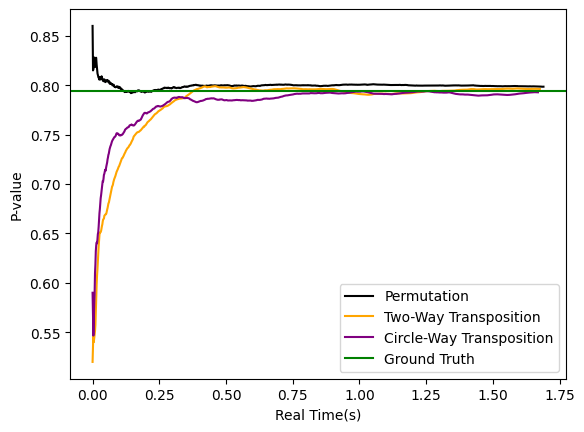

In [ ]:
plt.plot(np.linspace(0, perm_time, n_step1)/100, result_perm, color = 'black', label = 'Permutation')
plt.plot(np.linspace(0, twoway_time, n_step2)/100, result_twoway, color = 'orange', label = 'Two-Way Transposition')
plt.plot(np.linspace(0, circleway_time, n_step3)/100, result_circleway, color = 'purple', label = 'Circle-Way Transposition')
plt.xlabel('Real Time(s)')
plt.ylabel('P-value')
plt.axhline(y=p0value, color='green', linestyle='-', label = "Ground Truth")
plt.legend()
#plt.title('Example plot with labeled axes')
plt.show()